## **Import libraries**

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
                                    
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

## **Download the dataset**

Download the datasets from the below links.

https://drive.google.com/file/d/1-16czyoJl7r_Z09NuJ06wPaPkVCsffk7/view?usp=sharing

https://drive.google.com/file/d/1-H6FuinqOeGFVCEvoJAGSMw7V_wa3Lhf/view?usp=sharing

First link is without preprocessing, but the second link has been preprocessed.

Use the below link to know how to work with the data. The file "datasets_preparing.py" in the link can help you alot!

https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed


In [2]:
!gdown --id 1-16czyoJl7r_Z09NuJ06wPaPkVCsffk7

Downloading...
From: https://drive.google.com/uc?id=1-16czyoJl7r_Z09NuJ06wPaPkVCsffk7
To: /content/data0.pickle
100% 477M/477M [00:04<00:00, 107MB/s]


In [3]:
!gdown --id 1-H6FuinqOeGFVCEvoJAGSMw7V_wa3Lhf

Downloading...
From: https://drive.google.com/uc?id=1-H6FuinqOeGFVCEvoJAGSMw7V_wa3Lhf
To: /content/data3.pickle
100% 1.28G/1.28G [00:14<00:00, 88.4MB/s]


In [4]:
# import pickle

# # Importing other standard libraries
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# from tqdm import tqdm
# from pylab import text
# import csv
# from PIL import Image
# from skimage.transform import resize

In [5]:
def load_data(file):
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')  

        # for key in d:
        #   print(key)
        x_train = d['x_train']
        y_train = d['y_train']                        
        x_validation = d['x_validation']                         
        y_validation = d['y_validation']                                                 
        x_test = d['x_test'] 
        y_test = d['y_test']
        labels = d['labels']

    return x_train, y_train, x_validation, y_validation, x_test, y_test, labels

In [6]:
x_train_np, y_train_np, x_validation_np, y_validation_np, x_test_np, y_test_np, labels_np = load_data('/content/data0.pickle')

In [7]:
x_train_p, y_train_p, x_validation_p, y_validation_p, x_test_p, y_test_p, labels_p = load_data('/content/data3.pickle')

In [8]:
x_train_np = np.transpose(x_train_np, (0, 2, 3, 1))
x_validation_np = np.transpose(x_validation_np, (0, 2, 3, 1))
x_test_np = np.transpose(x_test_np, (0, 2, 3, 1))
x_train_np.shape

(86989, 32, 32, 3)

In [9]:
x_train_p = np.transpose(x_train_p, (0, 2, 3, 1))
x_validation_p = np.transpose(x_validation_p, (0, 2, 3, 1))
x_test_p = np.transpose(x_test_p, (0, 2, 3, 1))
x_train_p.shape

(86989, 32, 32, 3)

## **Display the dataset**

Plot some samples from the first dataset to see and know what are you working with. 

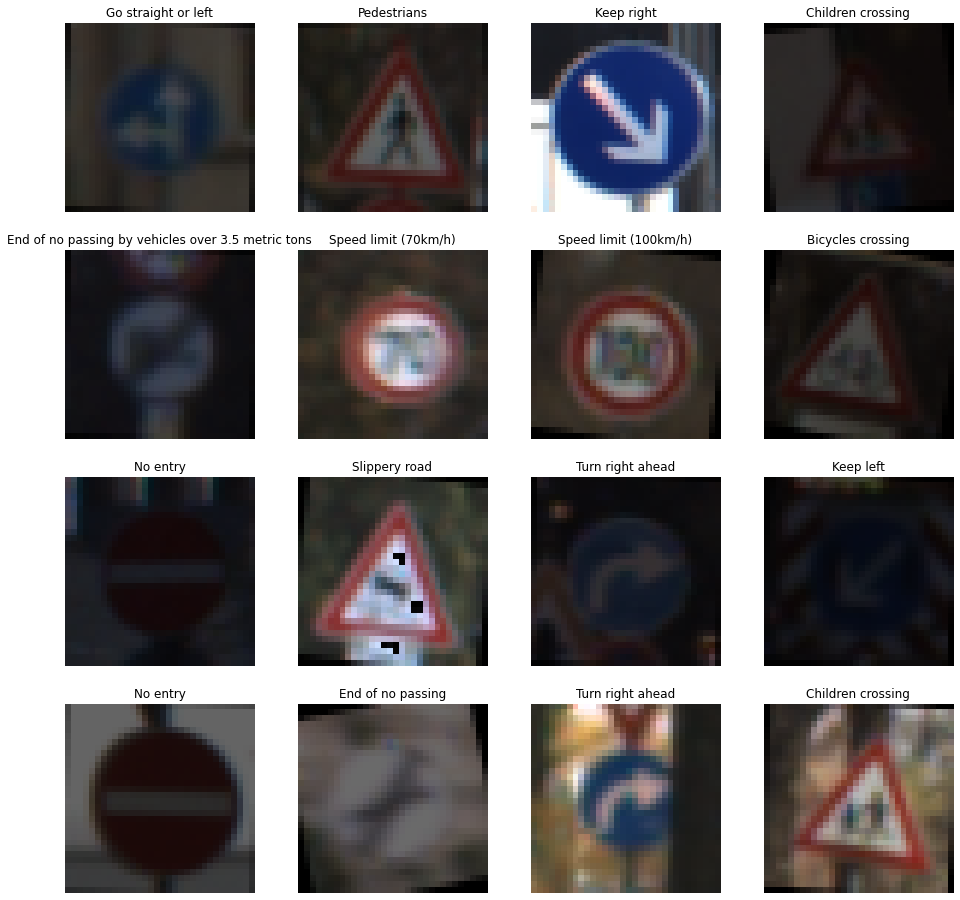

In [10]:
plt.figure(figsize=(16, 16))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(x_train_np[i])
  plt.title(labels_np[y_train_np[i]])
  plt.axis("off")


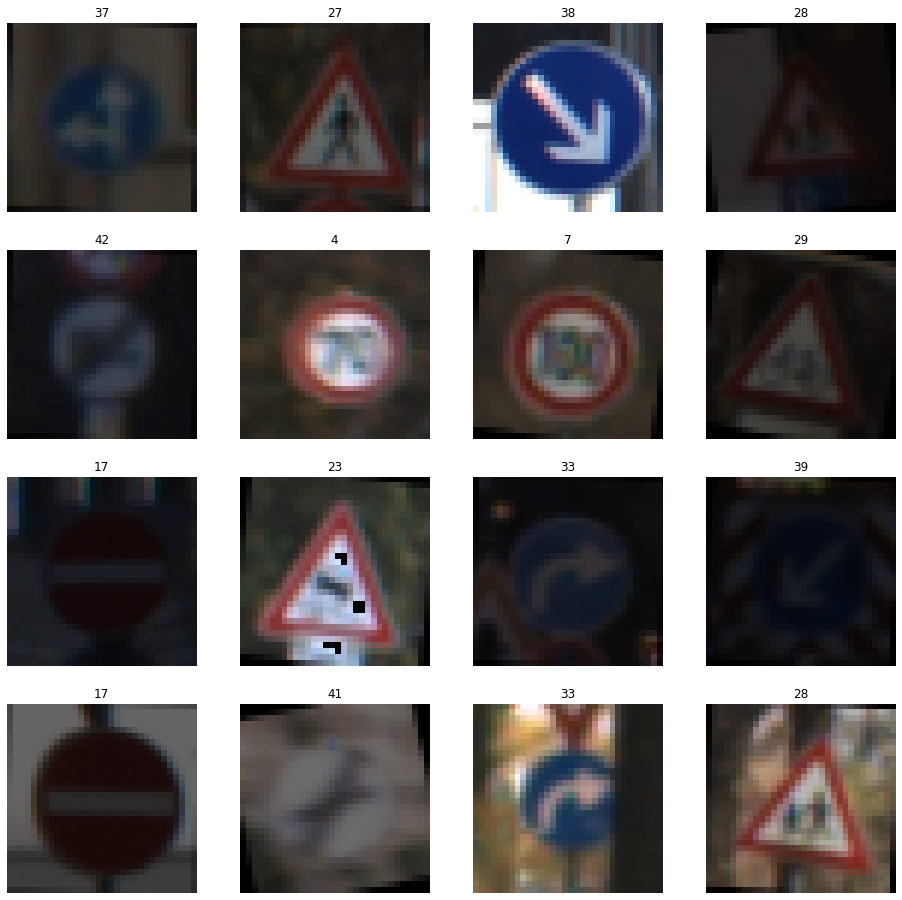

In [11]:
plt.figure(figsize=(16, 16))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(x_train_np[i])
  plt.title(y_train_np[i])
  plt.axis("off")

## **Build the ResNet Model**

Model's architecutre is given in the below tables. By entering each stage (except the first stage), the number of filters is doubled and the spatial resolution is halved. You should use appropriate hyperparameters (kernel-size, no-filter, ...) to achieve at least 85% accuracy.

<center>
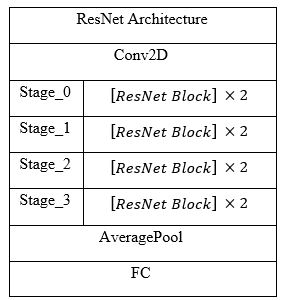
</center>
<h3><center> Model's architecture </center></h3>

<center>
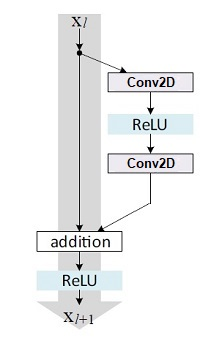
</center>

<h3><center> ResNet block architecture </center><h3>

In [35]:
def residual_block(x, downsample, filters, kernel_size=3):
  stride = 1
  if downsample:
    stride = 2
  f = Conv2D(kernel_size=kernel_size,
              strides= stride,
              filters=filters,
              padding="same")(x)
  f = Activation(tf.nn.relu)(f)
  f = Conv2D(kernel_size=kernel_size,
              strides=1,
              filters=filters,
              padding="same")(f)

  if downsample:
      x = Conv2D(kernel_size=1,
                  strides=stride,
                  filters=filters,
                  padding="same")(x)
  out = Add()([x, f])
  out = Activation(tf.nn.relu)(out)
  return out

def resnet(input_shape, optimizer, loss, metric, num_class):
    
    inputs = Input(shape=input_shape)
    num_filters = 64
    
    t = Conv2D(kernel_size=7,
               strides=1,
               filters=num_filters // 2,
               padding="same")(inputs)
    t = Activation(tf.nn.relu)(t)
    
    t = Conv2D(kernel_size=1,
                  strides=1,
                  filters=num_filters,
                  padding="same")(t)
    t = Activation(tf.nn.relu)(t)
    num_blocks_list = [2, 2, 2, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(num_class, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[metric]
    )

    return model

resnet_model = resnet((32, 32, 3), Adam(), tf.losses.SparseCategoricalCrossentropy(), 'accuracy', len(labels_p))

## **Plot the model**

Use the imported util to visualize the model.

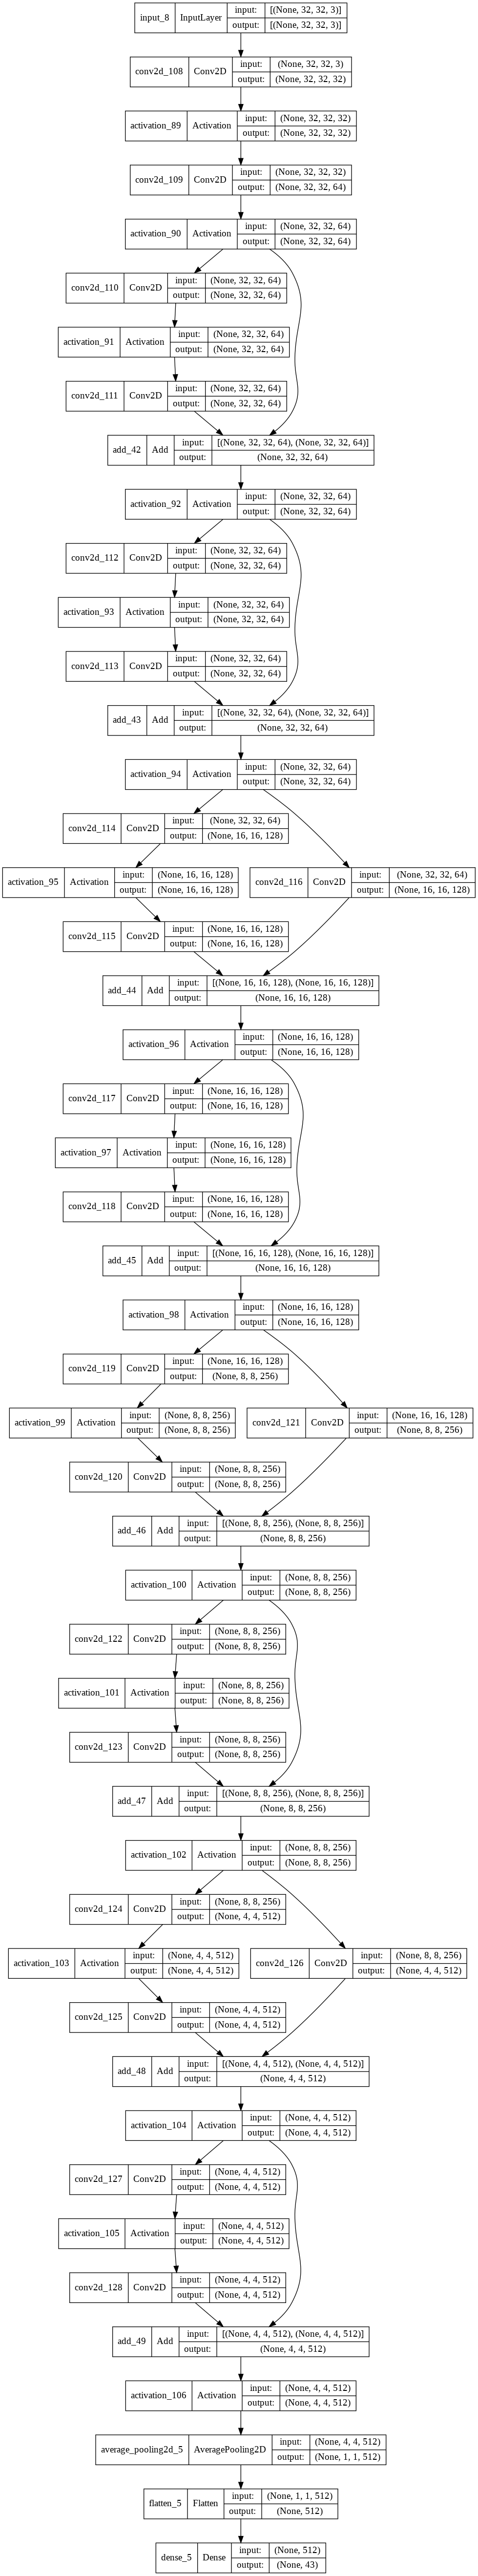

In [36]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)

## **Train the model**

Train the model on the second dataset (preprocessed)

In [37]:
epochs=10
history = resnet_model.fit(
    x=x_train_p,
    y=y_train_p,
    epochs=epochs,
    verbose=1,
    validation_data=(x_validation_p, y_validation_p),
    batch_size=128,
    shuffle=True
)

Epoch 1/10
680/680 [==============================] - 153s 222ms/step - loss: 1.8164 - accuracy: 0.4846 - val_loss: 0.5737 - val_accuracy: 0.8240
Epoch 2/10
680/680 [==============================] - 151s 222ms/step - loss: 0.1594 - accuracy: 0.9521 - val_loss: 0.4498 - val_accuracy: 0.8814
Epoch 3/10
680/680 [==============================] - 151s 221ms/step - loss: 0.0715 - accuracy: 0.9786 - val_loss: 0.3663 - val_accuracy: 0.9179
Epoch 4/10
680/680 [==============================] - 150s 221ms/step - loss: 0.0543 - accuracy: 0.9841 - val_loss: 0.3179 - val_accuracy: 0.9336
Epoch 5/10
680/680 [==============================] - 150s 220ms/step - loss: 0.0394 - accuracy: 0.9885 - val_loss: 0.4199 - val_accuracy: 0.9288
Epoch 6/10
680/680 [==============================] - 149s 220ms/step - loss: 0.0354 - accuracy: 0.9901 - val_loss: 0.3416 - val_accuracy: 0.9345
Epoch 7/10
680/680 [==============================] - 150s 220ms/step - loss: 0.0354 - accuracy: 0.9904 - val_loss: 0.2704 -

## **Test the model**

In [38]:
results = resnet_model.evaluate(x_test_p, y_test_p, batch_size=128)

99/99 [==============================] - 8s 75ms/step - loss: 0.3935 - accuracy: 0.9320


### **Plot loss and accuracy**

In this part you should plot the loss and accuracy of train and test.

Text(0.5, 1.0, 'Training and Validation Accuracy')

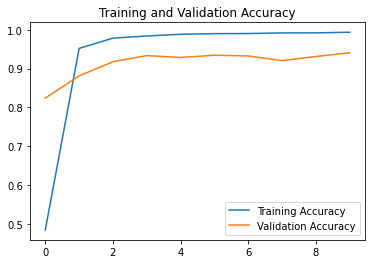

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



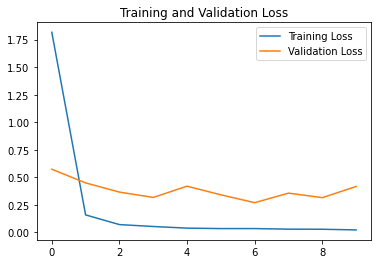

In [40]:

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()